## Imports and loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import random
from collections import Counter
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG: 
    # general configs
    seed = 42
    is_infer = True # set to false to replicate the training, and change n_hyper_trial to replicate the hyperparam tune process
    n_hyper_trial = 0 # set to 0 if you don't want to hyperparam tune
    site_name = "SHA" # for evaluation on field data 
    is_plot_level = False # set to true if you wish to inspect plot level distribution difference
    device = "GPU" # set to "CPU" if not using gpu

    # training configs
    n_epochs = 407
    lr = 0.20251769606182626
    l2_leaf_reg = 1.0118058664876357
    random_strength = 4.357195685324221
    bagging_temperature = 0.070891648878188
    depth = 9
    border_count = 207

**Result from 10 trials (test acc ~0.91):** \
Best trial: \
{'iterations': 724, 'depth': 9, 'learning_rate': 0.0804526265558996, 'l2_leaf_reg': 8.829789975843573, 'random_strength': 9.893533259541611, 'border_count': 250, 'bagging_temperature': 0.33973183826726416}

**Result from 20 trials (test acc ~0.93):** \
Best trial: \
{'iterations': 407, 'depth': 9, 'learning_rate': 0.20251769606182626, 'l2_leaf_reg': 1.0118058664876357, 'random_strength': 4.357195685324221, 'border_count': 207, 'bagging_temperature': 0.070891648878188}


In [3]:
# load in data
pft_code = pd.read_csv('./species_reference/FIATreeSpeciesCode_pft.csv',  sep=';')
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
pft_code['PFT'] = pft_code['PFT'].replace(replace_dict)

fia_ref_species_table = pd.read_csv('./species_reference/REF_SPECIES.csv')

plot_id = pd.read_csv("./field_data/01_plot_identification.csv")

tls_tree_ls = pd.read_csv("./terrestrial-lidar-scans-tls-and-derived-tree-lists-for-field-sampled-plots-for-uc-climate-actio/TLS_treelist.csv")
tls_tree_ls['DBH'] = tls_tree_ls['DBH'] * 0.0254 # scale set to meters

ff_tree = pd.read_csv('./FastFuel/FF_treelist_all.csv')
ff_tree['DIA'] = ff_tree['DIA'] / 100 # scale set to meters

In [4]:
# dicitonaries for mapping
blk_to_sitename = dict(zip(plot_id['plot_blk'], plot_id['site_name']))
sciname_to_pft = dict(zip(pft_code['SCI_NAME'], pft_code['PFT']))
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))
spcd_to_genus = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['GENUS']))
spcd_to_species = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['SPECIES']))
spcd_to_pft = {i:j for (i, j) in zip(pft_code['SPCD'], pft_code['PFT'])}
id_to_blk = dict(zip(plot_id['inventory_id'], plot_id['plot_blk']))

In [5]:
tls_tree_ls['site_name'] = tls_tree_ls['plot_blk'].map(blk_to_sitename) # additional feature 
tls_tree_ls

,Unnamed: 0,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,site_name
0,0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,0.533079,2.402324,CAFKU_0101_20240802_1,SHA
1,3,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,0.332887,0.936786,CAFKU_0101_20240802_1,SHA
2,4,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,1.519959,19.530404,CAFKU_0101_20240802_1,SHA
3,5,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,0.534438,2.414582,CAFKU_0101_20240802_1,SHA
4,6,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,0.416307,1.465130,CAFKU_0101_20240802_1,SHA
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,17,21,-9.820196,2.799561,0.220015,0.000291,30.631,1.3,0.440029,1.636854,CATCU_0016_20240929_1,NaN
1378,18,22,2.043417,-9.313768,0.308002,0.000450,23.077,1.3,0.616002,3.207835,CATCU_0016_20240929_1,NaN
1379,20,24,-8.147035,6.844047,0.226510,0.000211,30.127,1.3,0.453020,1.734931,CATCU_0016_20240929_1,NaN
1380,21,25,-2.692303,-8.172273,0.180451,0.000266,29.300,1.3,0.360901,1.101093,CATCU_0016_20240929_1,NaN


In [6]:
print(tls_tree_ls['X'].min(), tls_tree_ls['X'].max())
print(tls_tree_ls['Y'].min(), tls_tree_ls['Y'].max())
print(tls_tree_ls['Radius'].min(), tls_tree_ls['Radius'].max())

-11.2472481120952 11.2873500394915
-11.1884670454068 11.2704017551622
0.0 6.60106462953685


In the other notebook, we tried using the x and y coordinates of FF data to locate trees in the lidar maps through matching the plot_blk, which didn't work as the scale seems different and FF data are not field collected as well. The FIA data, although more specific, has not the coordinates of trees. With all that in mind, all I did here is a simple catboost + optuna for some features that seems to be shared in common between FF data and the TLS tree list.

In [7]:
# Shaver Lake - M261Ep
# Sedgwick Reserve - 261Ba
# Calaveras BigTrees - M261Em
# Pacific Union College - 263Am

In [8]:
# # inspect fia data
# fia_plot = pd.read_csv("./fia-database-california/CA_PLOT.csv")
# fia_tree = pd.read_csv("./fia-database-california/CA_TREE.csv")
# fia_data = pd.merge(fia_tree, fia_plot, left_on='PLT_CN', right_on='CN')
# fia_data['SPCD_encoded'] = fia_data['SPCD'].astype('category').cat.codes
# # corr with numerical features
# fia_data[['SPCD_encoded', 'CN_x', 'PLT_CN', 'INVYR_x', 'STATECD_x', 'UNITCD_x', 'COUNTYCD_x',
#        'PLOT_x', 'SUBP', 'TREE', 'CONDID', 'STATUSCD', 'SPCD', 'SPGRPCD',
#        'CYCLE_x', 'CN_y', 'SRV_CN', 'CTY_CN', 'INVYR_y', 'STATECD_y',
#        'UNITCD_y', 'COUNTYCD_y', 'PLOT_y', 'PLOT_STATUS_CD', 'MEASYEAR',
#        'MEASMON', 'MEASDAY', 'KINDCD', 'DESIGNCD', 'LAT', 'LON', 'CONGCD',
#        'MANUAL', 'SAMP_METHOD_CD', 'SUBP_EXAMINE_CD', 'CYCLE_y']].corr()['SPCD_encoded'].abs().sort_values(ascending = False)[:10]

In [9]:
# filter out rare classes
class_counts = Counter(ff_tree['SPCD'])
rare_classes = [cls for cls, count in class_counts.items() if count < 20]
mask = ~np.isin(ff_tree['SPCD'], rare_classes)
ff_tree = ff_tree[mask]
print("Rare classes:", rare_classes)

Rare classes: [11, 742, 63, 101, 351]


## Training

In [10]:
# train test split
ff_tree['site_name'] = ff_tree['site_name'].astype(str)
X = ff_tree[['HT', 'DIA', 'site_name']]
y = ff_tree['SPCD']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

tls_input = tls_tree_ls[['H', 'DBH', 'site_name']].rename({'H' : "HT", 'DBH' : 'DIA'}, axis = 1)

print(f"Training set size: {len(X_train)}")
print(f"Valid set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

Training set size: 436753
Valid set size: 54594
Test set size: 54595


In [11]:
# create catboost pools
categorical_features = ['site_name']
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "task_type": CFG.device,
        "random_seed": 42,
        "eval_metric": "Accuracy",
        "loss_function": "MultiClass",
        "verbose": 0,
    }
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=20, use_best_model=True)

    preds = model.predict(valid_pool)
    acc = accuracy_score(y_valid, preds)
    return acc
    
if CFG.n_hyper_trial:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=CFG.n_hyper_trial)  
    
    print("Best trial:")
    print(study.best_trial.params)

In [12]:
# load best parameters
if CFG.n_hyper_trial:
    best_params = study.best_trial.params
    best_params.update({
        "random_seed": 42,
        "eval_metric": "Accuracy",
        "loss_function": "MultiClass",
        "verbose": 100,
        "task_type": CFG.device,
        "early_stopping_rounds":0,
    })

    # remove unnecessary early stopping during final training
    best_params.pop("early_stopping_rounds", None)
    best_params.pop("use_best_model", None)
    
else:
    best_params = {
        'iterations': CFG.n_epochs,
        'depth': CFG.depth, 
        'learning_rate': CFG.lr, 
        'l2_leaf_reg': CFG.l2_leaf_reg, 
        'random_strength': CFG.random_strength, 
        'border_count': CFG.border_count, 
        'bagging_temperature': CFG.bagging_temperature,
        "random_seed": CFG.seed,
        "eval_metric": "Accuracy",
        "loss_function": "MultiClass",
        "verbose": 100,
        "task_type": CFG.device,
    }

if not CFG.is_infer:
    # combine train + valid for final training
    X_train_valid = pd.concat([X_train, X_valid], axis=0)
    y_train_valid = np.concatenate([y_train, y_valid], axis=0)
    full_train_pool = Pool(X_train_valid, y_train_valid, cat_features=categorical_features)
    
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(full_train_pool)
    
    # evaluate on test set
    preds = final_model.predict(test_pool)
    acc = accuracy_score(y_test, preds)
    
    final_model.save_model("tls_catboost_v3.cbm")
    print("Final test accuracy:", acc)

else:
    # load the model weights
    final_model = CatBoostClassifier(**best_params)
    fianl_model = final_model.load_model("tls_catboost_v3.cbm")

In [13]:
# predict tls
for col in categorical_features:
    tls_input[col] = tls_input[col].astype(str)
inference_pool = Pool(tls_input, cat_features=categorical_features)
predicted_spcd = final_model.predict(inference_pool)

In [14]:
# map results onto the tls data
tls_tree_ls['SPCD'] = predicted_spcd
tls_tree_ls['PFT'] = tls_tree_ls['SPCD'].map(spcd_to_pft)
tls_tree_ls['COMMON_NAME'] = tls_tree_ls['SPCD'].map(spcd_to_common_name)
tls_tree_ls['SPECIES'] = tls_tree_ls['SPCD'].map(spcd_to_species)
tls_tree_ls['GENUS'] = tls_tree_ls['SPCD'].map(spcd_to_genus)
tls_tree_ls.head()

,Unnamed: 0,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,site_name,SPCD,PFT,COMMON_NAME,SPECIES,GENUS
0,0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,0.533079,2.402324,CAFKU_0101_20240802_1,SHA,81,Evergreen conifer,incense-cedar,decurrens,Calocedrus
1,3,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,0.332887,0.936786,CAFKU_0101_20240802_1,SHA,81,Evergreen conifer,incense-cedar,decurrens,Calocedrus
2,4,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,1.519959,19.530404,CAFKU_0101_20240802_1,SHA,81,Evergreen conifer,incense-cedar,decurrens,Calocedrus
3,5,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,0.534438,2.414582,CAFKU_0101_20240802_1,SHA,81,Evergreen conifer,incense-cedar,decurrens,Calocedrus
4,6,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,0.416307,1.465130,CAFKU_0101_20240802_1,SHA,81,Evergreen conifer,incense-cedar,decurrens,Calocedrus


## Evaluate on field data

In [15]:
# load field data
field_treelist = pd.read_csv('./field_data/03_tree.csv')
plot_inventory = pd.read_csv("./field_data/01_plot_identification.csv")
replace_dict = {'Salix sp.': 'Salix spp.', 'Quercus sp.': 'Quercus spp.', 'Cornus nuttalii': 'Cornus nuttallii'} 
field_treelist['tree_sp_scientific_name'] = field_treelist['tree_sp_scientific_name'].replace(replace_dict)

# filter by site
site_name = CFG.site_name # change here if you wish to visualize results on other sites
site_inv = plot_inventory.loc[plot_inventory.site_name == site_name, ['inventory_id', 'plot_blk']]
tls_treelist_site = tls_tree_ls[tls_tree_ls.site_name == site_name].copy()
field_treelist_site = field_treelist[field_treelist.inventory_id.isin(site_inv.inventory_id)].copy()

# infer genus and species using our maps
tls_treelist_site['scientific_name'] = tls_treelist_site['GENUS'] + ' ' + tls_treelist_site['SPECIES']
field_treelist_site['PFT'] = field_treelist_site['tree_sp_scientific_name'].map(sciname_to_pft)
field_treelist_site['genus'] = field_treelist_site['tree_sp_scientific_name'].str.split().str[0]
field_treelist_site['species'] = field_treelist_site['tree_sp_scientific_name'].str.split().str[1]
field_treelist_site['plot_blk'] = field_treelist_site['inventory_id'].map(id_to_blk)

uncomment the following if you wish to visualize the distribution comparison from random plot at the selected site

In [16]:
# choose a random plot
if CFG.is_plot_level:
    unique_plots = field_tresslist_site['plot_blk'].unique()
    random_plot = random.choice(unique_plots)
    field_treelist_plot = field_tresslist_site[field_tresslist_site.plot_blk == random_plot].copy()
    tls_treelist_plot = tls_treelist_site[tls_treelist_site.plot_blk == random_plot].copy()

### Visualize

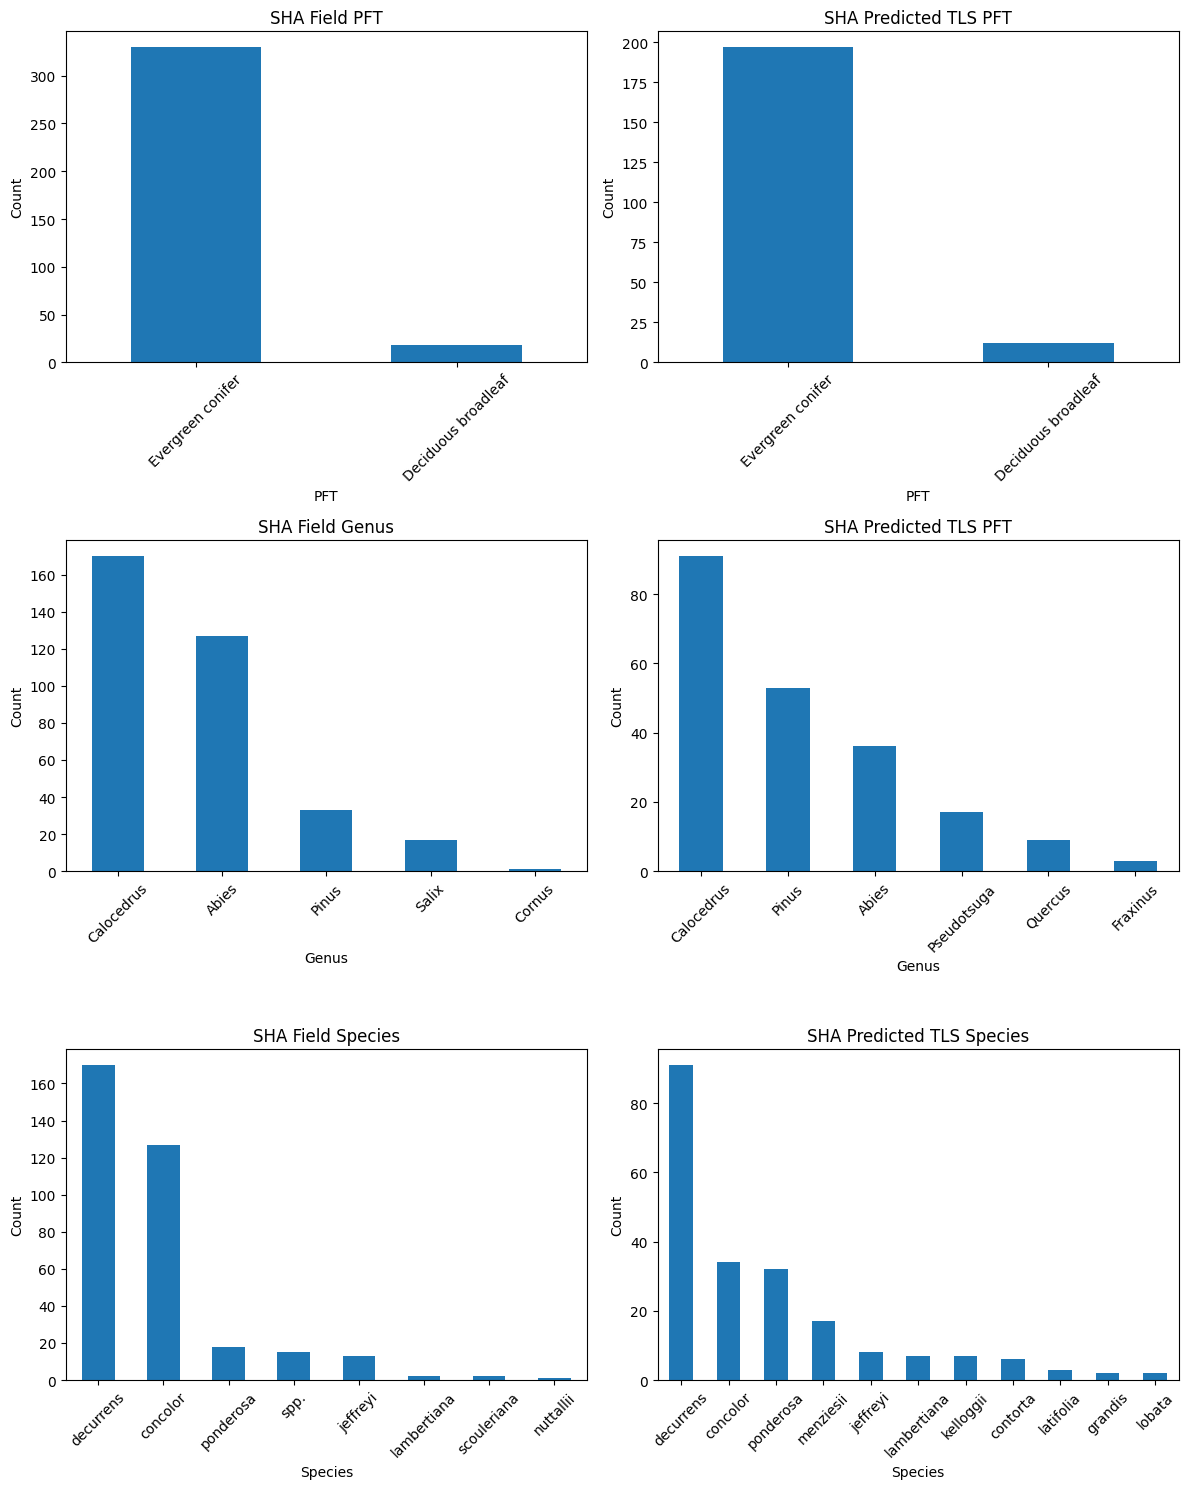

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Data to plot: (df, col_name, subplot idx, title)
if CFG.is_plot_level:
    plot_config = [
        (field_treelist_plot, "PFT",  (0, 0), f"{site_name} Field PFT"),
        (tls_treelist_plot,   "PFT",  (0, 1), f"{site_name} Predicted TLS PFT"),
        (field_treelist_plot, "genus", (1, 0), f"{site_name} Field Genus"),
        (tls_treelist_plot,   "GENUS",  (1, 1), f"{site_name} Predicted TLS PFT"),
        (field_treelist_plot, "species", (2, 0), f"{site_name} Field Species"),
        (tls_treelist_plot,   "SPECIES",  (2, 1), f"{site_name} Predicted TLS Species"),
    ]
else:
    plot_config = [
        (field_treelist_site, "PFT",  (0, 0), f"{site_name} Field PFT"),
        (tls_treelist_site,   "PFT",  (0, 1), f"{site_name} Predicted TLS PFT"),
        (field_treelist_site, "genus", (1, 0), f"{site_name} Field Genus"),
        (tls_treelist_site,   "GENUS",  (1, 1), f"{site_name} Predicted TLS PFT"),
        (field_treelist_site, "species", (2, 0), f"{site_name} Field Species"),
        (tls_treelist_site,   "SPECIES",  (2, 1), f"{site_name} Predicted TLS Species"),
    ]

# plot
for df, col, idx, title in plot_config:
    ax = axs[idx]
    df[col].value_counts().plot(kind="bar", ax=ax)
    ax.set_xlabel(str(col).title() if col != "PFT" else "PFT")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()